# BE/Bi 103, Fall 2015: Homework 5
## Due 1pm, Monday, November 9

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw5.ipynb).*

In [1]:
import warnings

# The workhorses
import pandas as pd

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.patches

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem 5.1: Dancing statistics (100 pts)

*This problem was inspired by Geoff Cumming.*

In this problem, we will investigate how **replicable** certain statistical conclusions, both the frequentist and Bayesian contexts, are.  What I mean by replicability is best understood be working through the problem.

For this tutorial we will use the zebrafish embryo sleep data we have been using before.  We will investigate one of the metrics we considered in [Tutorial 2b](../tutotials/t2b_defining_and_estimating_parameters.html).  We will study the mean rest bout length on the third night, comparing wild type to the homozygous mutant.  You could work through Tutorial 2b again to process the bout lengths and get the data, but I provide them for you [here](../data/mean_rest_bouts.csv).

As a reminder, two of the mutant fish had no detectable rest bouts on the one-minute sampling interval.  They obviously did have rest bouts, but they were smaller than one minute.  We therefore have a decision: we can either choose the mean rest bout length to be zero for these fish, or we can jettison them from our samples because we know we could not properly sample them.  For the purposes of this problem, we will include these fish and take their mean bout length to be zero.

Let's remind ourselves of what the data look like.

In [2]:
# Load data
df = pd.read_csv('../data/gandhi_et_al/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)

Let's look at these data with a jitter plot.

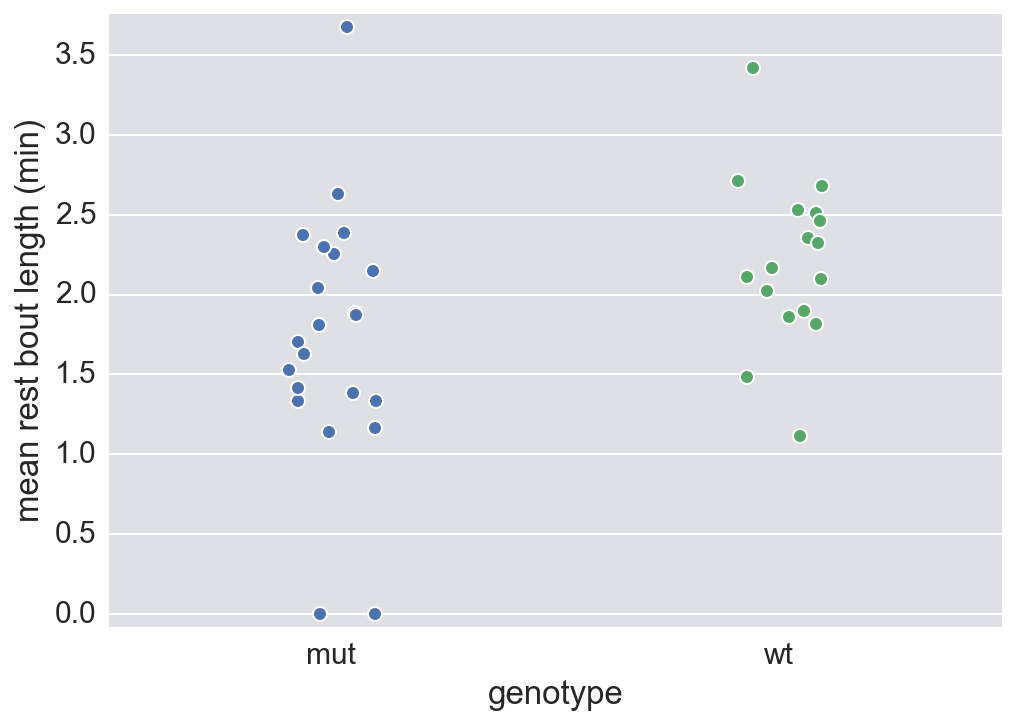

In [3]:
# Make strip plot
sns.stripplot(x='genotype', y='mean_rest_bout_length', data=df, jitter=True)

# Label axes 
plt.ylabel('mean rest bout length (min)')
plt.margins(y=0.02)

By eye, is looks like the wild type has a longer mean rest bout length than the mutant.  We will investigate this claim using parametric frequentist and Bayesian methods.  We will assume these data are Gaussian distributed each with their own mean $\mu$ and variance $\sigma^2$.

**a)** Estimate the values of $\mu$ and $\sigma^2$ for the wild type and mutant populations using an unbiased frequentist estimator.  We will denote these as $\mu_w$, $\sigma^2_w$, $\mu_m$, and $\sigma^2_m$.  Also compute Cohen's d to measure the effect size between these two.

**b)** Compute a frequentist estimate for the difference of the means, $\delta \equiv \mu_w - \mu_m$ and a reasonable 95% confidence interval.

**c)** Compute a reasonable Bayesian estimate for $\delta$ and give a credible region.

**d)** Consider the hypothesis $H_0$, which says that the mutant and wild type populations are drawn from the same Gaussian distribution.  Perform a frequentist hypothesis test to compute the p-value corresponding to this hypothesis.

**e)** Consider hypothesis $H_1$ that says that they are drawn from different Gaussian distributions with their own mean $\mu$ and variance $\sigma^2$, as we assumed at the beginning.  Compute an approximate Bayesian odds ratio,

\begin{align}
O_{01} = \frac{P(H_0\mid D, I)}{P(H_1\mid D, I)}.
\end{align}

\textit{Hint}: Some of the results from lecture 2 might make this calculation easier.  In fact, you can use some fairly simple analytical results to quickly compute the odds ratio.  Or you have hit it with an MCMC hammer if you feel like giving your computer a workout.

**f)** We will now "repeat" the experiment.  Generate a set of mean sleep bout lengths for 17 wild type fish by drawing the bout lengths out of a Gaussian distribution with mean $\mu_w$ and variance $\sigma_w^2$, using the values you estimated in part (a).  Do the same for 22 mutant fish using $\mu_m$ and $\sigma_m$ as estimated in part (a).  For this new group of fish, repeat parts (b) through (e).  That is, compute the frequentist confidence interval for $\delta$, a Bayesian credible region for $\delta$, a frequentist p-value for hypothesis $H_0$, and a Bayesian odds ratio $O_{01}$.  

Do this procedure, where you generate new data from your mean and variances in part (a) and compute these quantities, 100 times.  Make plots that show how the confidence intervals, credible regions, p-values, and odds ratios "dance" as you repeat the experiment.  What lessons do you take away from this?

<br />

### Problem 5.2: Outliers in FRET binding curve (10 pts extra credit)

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imaging two proteins, $a$ and $b$ may bind to each other in the reaction

\begin{align}
ab \rightleftharpoons a + b
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of $a$ and $b$ to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed and measure $c_{ab}$ for various $c_b^0$.  We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$.  For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of $a$ is bound to $b$.  Specifically, we take $a$ with a fluorophore and $b$ is a receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molcule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume.  We define by $e$ the FRET efficiency,

\begin{align}
e = 1 - \frac{f}{f_0}.
\end{align}

If we measure $F_0$, the measured fluorescence when there is no b protein in the sample, we can compute the FRET efficiency from  the measured values $F$ and $F_0$

\begin{align}
e =  1 - \frac{c_a^0\,V f}{c_a^0\,Vf_0} = 1 - \frac{F}{F_0}.
\end{align}

Substituting in our expressions for $F$ and $F_0$, we get

\begin{align}
e = 1 - \frac{\left(c_a \,f_0 + c_{ab}\, f_q\right)V}{c_a^0\,V f_0}
= 1 - \frac{c_a}{c_a^0} - \frac{c_{ab}}{c_a^0}\,\frac{f_q}{f_0}.
\end{align}

Using the fact that $c_a^0 = c_a + c_{ab}$, this becomes

\begin{align}
e = \left(1-\frac{f_q}{f_0}\right)\frac{c_{ab}}{c_a^0}.
\end{align}

In other words, the FRET efficiency is proportional to the fraction of a that is bound, or

\begin{align}
e = \alpha \, \frac{c_{ab}}{c_a^0} = \frac{2\alpha\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}},
\end{align}

where $\alpha = 1-f_q/f_0$.  So, we perform a regression with two phenomenological parameters to fit, $\alpha$ and $K_d$.

**a)** Load in the data for one of these FRET efficiency titration curves.  You can download the data set [here](../data/fret_binding_curve.csv).  Compute the background-subtracted fluorescence and the FRET efficiency.  *These are real data, graciously donated by Emily Blythe, a student in last year's class.  This is from a novel assay, and the identities of the proteins are hidden.  If you are interested in the proteins they are studying, please ask me and we can discuss.*

**b)** Perform regressions to find $K_d$ with and without an outlier detection scheme.  How do the results differ?

<br />

### Problem 5.3: Analysis of connections in the human brain (up to 30 pts extra credit)

Use the techniques covered in [Recitation 4](http://bebi103.caltech.edu/2015/protected/tutorials/r4_lasso_ridge.html), or whatever else you would like to try, to try to predict psychological metric from brain connectivity.  You can download the data sets [here](http://bebi103.caltech.edu/2015/protected/data/brain_correlation.zip).